[home](http://www.brandonrose.org)

## [ 2010~2017, 7년간의 gni 연구 동향을 비지도학습으로 알아보기 ]

### ------------------------------------------------ 1771015 김유진 ------------------------------------------------

# Document Clustering with Python

<img src='header_short.jpg'>

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). See [the original post](http://www.brandonrose.org/top100) for a more detailed discussion on the example. This guide covers:

<ul>
<li> tokenizing and stemming each synopsis
<li> transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
<li> plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
<li> conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> plotting a Ward dendrogram
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
</ul>

But first, I import everything I am going to need up front

In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

# Stopwords, stemming, and tokenizing

In [2]:
#2010~2017, 7년간의 GNI의 sent_tokenize 버전 경로를 GNIpath로 함
GNIpath=r'C:\Users\kimyujin\Desktop\2020 3-2학기\인공지능\sentence_tokenized'  
#GNIpath에서 파일들을 읽어옴
GNIfiles=os.listdir(GNIpath)
GNIfilename=[]
#GNIfilename은 '~.txt' 형태이므로 끝에서 4개의 문자를 제외한 나머지 부분을 GNIfilename으로 설정함
for i in range(0,len(GNIfiles)):
    GNIfilename.append(GNIfiles[i][:-4])

#이 때, 클러스터링 결과물의 clearity를 위해 100개 단위로 나누어서 보기로 함
GNIfilename=GNIfilename[:100]

In [3]:
filepath=[]
#filepath 리스트를 만듦
for i in range(0,len(GNIfiles)):
    filepath.append(GNIpath+'\\'+GNIfiles[i])

In [4]:
#paperContent 리스트에 논문 내용을 저장함
paperContent=[]
for i in range(0,len(GNIfiles)):
    f=open(filepath[i],encoding='utf-8')
    paperContent.append(f.read())
#paperContent도 100개 단위로 나누어줌
paperContent=paperContent[:100]

In [5]:
#year 리스트에는 각 논문의 발행 연도를 저장함. 이 때, 발행연도는 조사 결과 파일 명에서 gni 바로 다음에 오는 숫자 +2002 였음
years = []
for i in range(0,len(filepath)):
    years.append(2002+int(filepath[i][65:67]))
#years도 100개 단위로 나누어줌
years=years[:100]

In [6]:
print(str(len(GNIfilename)) + ' GNIfilename')
print(str(len(paperContent)) + ' paperContent')
print(str(len(years)) + ' years')

100 GNIfilename
100 paperContent
100 years


In [7]:
order_p = []
#order_p는 단순히 순서를 나타내주기 위해 사용되는 리스트임
for i in range(0,len(GNIfilename)):
    order_p.append(i)

This section is focused on defining some functions to manipulate the synopses. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [8]:
#stopword 제거를 위해 nltk의 stopword를 사용함
stopwords = nltk.corpus.stopwords.words('english')

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [9]:
#기존의 SnowballStemmer 대신 WordNetLemmatizer를 사용해봄
#이는 단어의 원형을 찾아주어, 더 정확한 키워드 분석을 위함임
from nltk.stem.wordnet import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [10]:
#알파벳으로 구성된 단어의 원형을 찾아주는 tokenize_and_lemma()를 정의함
def tokenize_and_lemma(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lemma = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lemma

In [11]:
#lemmatize되기 전의 원형 단어만을 추출해주는 함수 tokenize_only()를 정의함
def tokenize_only(text):
    
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [12]:
#paperContent에 대해 단어 원형과, 단어 원본을 각각의 리스트에 저장해 줌
totalvocab_lemma = []
totalvocab_tokenized = []
for i in paperContent:
    allwords_lemma = tokenize_and_lemma(i)
    totalvocab_lemma.extend(allwords_lemma)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [13]:
print(totalvocab_lemma[200:210]) #단어의 원형
print(totalvocab_tokenized[200:210]) #텍스트 속 단어 원본

['assembly', 'in', 'any', 'whole-genome', 'sequenced', 'specie', 'The', 'and', 'coverage', 'of']
['assembly', 'in', 'any', 'whole-genome', 'sequenced', 'species', 'the', 'and', 'coverage', 'of']


Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [14]:
#단어 원형에 대한 단어 원본을 보여주는 dataframe인 vocab_frame을 구성함 
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_lemma)
vocab_frame[500:520]

,words
application,applications
of,of
creative,creative
energy,energy
source,sources
biofuels,biofuels
clean,clean
up,up
of,of
toxic,toxic


## Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [15]:
#논문에 등장한 단어의 상대적인 빈도를 나타내주는 tfidf_matrix를 만듦 
from sklearn.feature_extraction.text import TfidfVectorizer
#stopwords는 제외시키고, tokenizer는 tokenize_and_lemma로 둚
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_lemma, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(paperContent)

print(tfidf_matrix.shape)

C:\Users\kimyujin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 5.79 s
(100, 570)


In [16]:
#terms는 tfidf_vectorizer에서 term들을 추출하여 만듦
terms = tfidf_vectorizer.get_feature_names()
terms

["'s",
 'ability',
 'according',
 'accuracy',
 'acid',
 'activity',
 'added',
 'addition',
 'additional',
 'advance',
 'advanced',
 'advantage',
 'affect',
 'affected',
 'affymetrix',
 'age',
 'al',
 'algorithm',
 'allele',
 'allele frequency',
 'alternative',
 'amino',
 'amino acid',
 'amplification',
 'analyze',
 'analyzed',
 'and/or',
 'annotation',
 'application',
 'applied',
 'approach',
 'approximately',
 'area',
 'array',
 'assay',
 'associated',
 'association',
 'association study',
 'available',
 'average',
 'b',
 'base',
 'based',
 'basis',
 'best',
 'better',
 'binding',
 'bioinformatics',
 'biological',
 'biology',
 'blood',
 'body',
 'bp',
 'c',
 'ca',
 'ca usa',
 'calculated',
 'called',
 'cancer',
 'candidate',
 'carried',
 'case',
 'category',
 'cause',
 'caused',
 'cell',
 'cell line',
 'cellular',
 'center',
 'certain',
 'challenge',
 'change',
 'characteristic',
 'chromosome',
 'class',
 'clinical',
 'cluster',
 'coding',
 'cohort',
 'collected',
 'collection',
 'com

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [18]:
from sklearn.cluster import KMeans
#cluster 개수는 5로 두었다.
num_clusters = 5 
#KMeans를 이용해 제곱합을 최소로 하여, 5개의 클러스터로 묶기로 함 
km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 1.13 s


In [19]:
from sklearn.externals import joblib

#joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

C:\Users\kimyujin\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\kimyujin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\kimyujin\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator KMeans from version pre-0.18 w

In [20]:
import pandas as pd

GnIpaper = { 'Paper': GNIfilename, 'Order': order_p, 'Content': paperContent, 'cluster': clusters, 'Year': years}
#GNI에 대한 dataframe을 만든다.
frame = pd.DataFrame(GnIpaper, index = [clusters] , columns = ['Order','Paper', 'cluster', 'Year'])

In [21]:
#frame.head(10)
frame.tail(10)

,Order,Paper,cluster,Year
1,90,gni-12-1-1,1,2014
1,91,gni-12-1-12,1,2014
2,92,gni-12-1-2,2,2014
0,93,gni-12-1-21,0,2014
1,94,gni-12-1-35,1,2014
1,95,gni-12-1-42,1,2014
2,96,gni-12-2-49,2,2014
1,97,gni-12-2-50,1,2014
1,98,gni-12-2-58,1,2014
3,99,gni-12-2-64,3,2014


In [22]:
#cluster 0~4가 각각 몇개의 논문으로 구성되어있는지 출력해본다
frame['cluster'].value_counts()

4    26
0    25
2    21
1    16
3    12
Name: cluster, dtype: int64

In [23]:
#order가 순위일때는 의미있었지만, gni에 대해서는 order가 단순한 '순서' 이므로 해당 셀은 지운다.
#grouped = frame['Order'].groupby(frame['cluster'])

#grouped.mean()

In [24]:
from __future__ import print_function

#각 클러스트의 대표 단어, 즉 키워드 역할을 해줄 단어들을 뽑아낸다.
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    #상위 5개를 대표 단어로 추출해보았다.
    for ind in order_centroids[i, :5]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    #각 클러스트에 속한 논문들도 출력해본다. 
    print("Cluster %d Paper:" % i, end='')
    for title in frame.loc[i]['Paper'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'frequency', b'ii', b'measure', b'technique', b'improve',

Cluster 0 Paper: gni-10-1-23, gni-10-1-44, gni-10-1-51, gni-10-1-65, gni-10-1-9, gni-10-2-74, gni-10-3-133, gni-10-3-153, gni-10-4-226, gni-10-4-271, gni-11-1-24, gni-11-1-34, gni-11-1-38, gni-11-1-46, gni-11-2-97, gni-11-2-99, gni-11-4-164, gni-11-4-174, gni-11-4-180, gni-11-4-200, gni-11-4-211, gni-11-4-230, gni-11-4-254, gni-11-4-282, gni-12-1-21,

Cluster 1 words: b'pairs', b'components', b'isolated', b'mechanisms', b'et',

Cluster 1 Paper: gni-10-1-40, gni-10-2-117, gni-10-2-123, gni-10-2-128, gni-10-3-167, gni-10-4-214, gni-11-2-83, gni-11-3-114, gni-11-4-191, gni-11-4-272, gni-12-1-1, gni-12-1-12, gni-12-1-35, gni-12-1-42, gni-12-2-50, gni-12-2-58,

Cluster 2 words: b'functional', b'model', b'variety', b'minor', b'combination',

Cluster 2 Paper: gni-10-1-1, gni-10-1-33, gni-10-1-58, gni-10-2-110, gni-10-2-69, gni-10-3-206, gni-10-4-266, gni-11-1-15, gni-11-1-58, gni-11-1-7, gni-1

In [25]:
#order는 0부터 구성되어있으므로, 1부터 구성될 수 있도록 1을 더해준다.
frame['Order'] = frame['Order'] + 1
frame['Paper'] = frame['Paper']

In [26]:
#HTML로 출력해보기. 여기서는 cluster 1에 대한 논문명들로 구성된 테이블 형태를 출력했다.
print(frame[['Order', 'Paper']].loc[frame['cluster'] == 1].to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Order</th>
      <th>Paper</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>5</td>
      <td>gni-10-1-40</td>
    </tr>
    <tr>
      <td>13</td>
      <td>gni-10-2-117</td>
    </tr>
    <tr>
      <td>14</td>
      <td>gni-10-2-123</td>
    </tr>
    <tr>
      <td>15</td>
      <td>gni-10-2-128</td>
    </tr>
    <tr>
      <td>24</td>
      <td>gni-10-3-167</td>
    </tr>
    <tr>
      <td>31</td>
      <td>gni-10-4-214</td>
    </tr>
    <tr>
      <td>57</td>
      <td>gni-11-2-83</td>
    </tr>
    <tr>
      <td>64</td>
      <td>gni-11-3-114</td>
    </tr>
    <tr>
      <td>77</td>
      <td>gni-11-4-191</td>
    </tr>
    <tr>
      <td>87</td>
      <td>gni-11-4-272</td>
    </tr>
    <tr>
      <td>91</td>
      <td>gni-12-1-1</td>
    </tr>
    <tr>
      <td>92</td>
      <td>gni-12-1-12</td>
    </tr>
    <tr>
      <td>95</td>
      <td>gni-12-1-35</td>
    </tr>
    <t

# Multidimensional scaling

In [27]:
import os 

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()
#다차원 스케일링을 이용하여 데이터 간의 관계를 구성할 수 있다

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  

xs, ys = pos[:, 0], pos[:, 1]

In [28]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag
#proper noun으로 포스태깅된 단어를 제외하여 non_propernouns 리스트를 만든다
def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Visualizing document clusters

In [29]:

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

# 상위 단어들로 클러스트 네임을 지정한다
cluster_names = {0: 'frequency, measure, technique', 
                 1: 'pairs, components, isolated', 
                 2: 'functional, model, variety', 
                 3: 'genomics, developed, review', 
                 4: 'isolated, scores, complete'
                }

In [30]:
%matplotlib inline

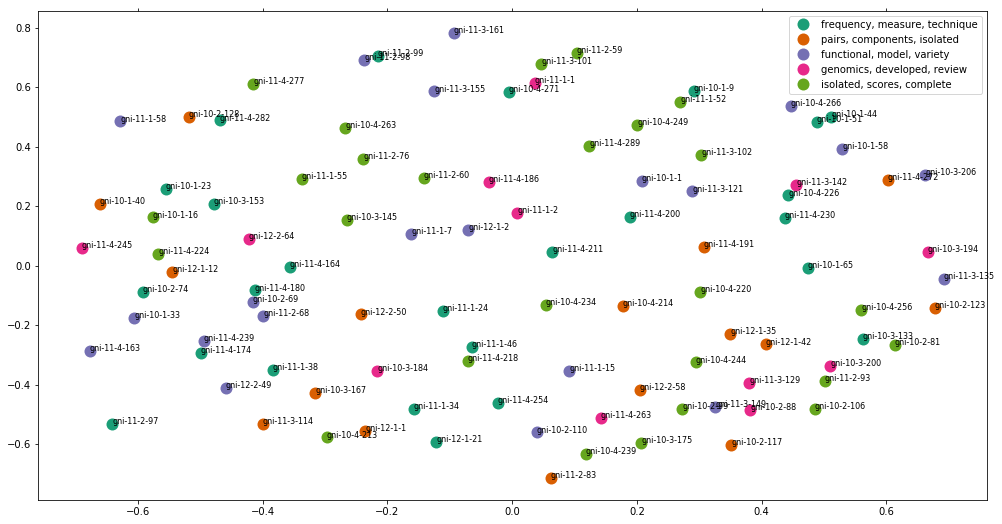

In [31]:
#위에서 얻은 다차원 스케일링의 결과와 클러스터링을 이용해 dataframe을 구축한다
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, GNIfile=GNIfilename)) 

#clusters를 기준으로 그룹화 한다
groups = df.groupby('label')



fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05)

#클러스터를 기준으로 그룹화된 결과에 대해 plot 세팅을 설정한다.
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         
        which='both',     
        bottom='off',     
        top='off',      
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         
        which='both',      
        left='off',      
        top='off',         
        labelleft='off')
    
ax.legend(numpoints=1)  


#GNI의 클러스터 결과를 그려줌. 클러스터 결과는 2010~2017의 7년간 논문 동향을 키워드를 기준으로 보여줌
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['GNIfile'], size=8)  

    
    
plt.show() #show the plot



In [32]:
plt.close()

The clustering plot looks great, but it pains my eyes to see overlapping labels. Having some experience with [D3.js](http://d3js.org/) I knew one solution would be to use a browser based/javascript interactive. Fortunately, I recently stumbled upon [mpld3](https://mpld3.github.io/) a matplotlib wrapper for D3. Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

-------------------------------------------------